<a href="https://colab.research.google.com/github/Gousepasha789/Tea-Leaf-disease-detection/blob/main/tealeaf_disease_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Step 1: Import required libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import layers, models
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
import numpy as np
import os

print("All required libraries imported successfully!")

All required libraries imported successfully!


In [2]:
# Step 2: Mount Google Drive and load dataset

from google.colab import drive
drive.mount('/content/drive')

# Dataset base path
base_path = "/content/drive/MyDrive/teaLeafBD"

print("Google Drive mounted successfully!")
print(f"Dataset Path set to: {base_path}")

Mounted at /content/drive
Google Drive mounted successfully!
Dataset Path set to: /content/drive/MyDrive/teaLeafBD


In [3]:
# Step 3: Define image parameters

IMAGE_SIZE = (128, 128)
BATCH_SIZE = 32
CHANNELS = 3

print("Image parameters set successfully!")
print(f"Image Size     : {IMAGE_SIZE}")
print(f"Batch Size     : {BATCH_SIZE}")
print(f"Channels       : {CHANNELS} (RGB)")

Image parameters set successfully!
Image Size     : (128, 128)
Batch Size     : 32
Channels       : 3 (RGB)


In [4]:
# Step 4: Create Data Generators & Load Dataset

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range=[0.8, 1.2]
)

val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_data = train_datagen.flow_from_directory(
    base_path,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_data = val_datagen.flow_from_directory(
    base_path,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

print("\nDataset Loaded Successfully!")
print(f"Training samples   : {train_data.samples}")
print(f"Validation samples : {val_data.samples}")
print(f"Number of Classes  : {train_data.num_classes}")
print("Classes:", list(train_data.class_indices.keys()))

Found 4223 images belonging to 7 classes.
Found 1053 images belonging to 7 classes.

Dataset Loaded Successfully!
Training samples   : 4223
Validation samples : 1053
Number of Classes  : 7
Classes: ['1. Tea algal leaf spot', '2. Brown Blight', '3. Gray Blight', '4. Helopeltis', '5. Red spider', '6. Green mirid bug', '7. Healthy leaf']



Class Labels Mapping:
   0 → 1. Tea algal leaf spot
   1 → 2. Brown Blight
   2 → 3. Gray Blight
   3 → 4. Helopeltis
   4 → 5. Red spider
   5 → 6. Green mirid bug
   6 → 7. Healthy leaf

Dataset Analysis:
Total Training Samples   : 4223
Total Validation Samples : 1053
Number of Classes        : 7


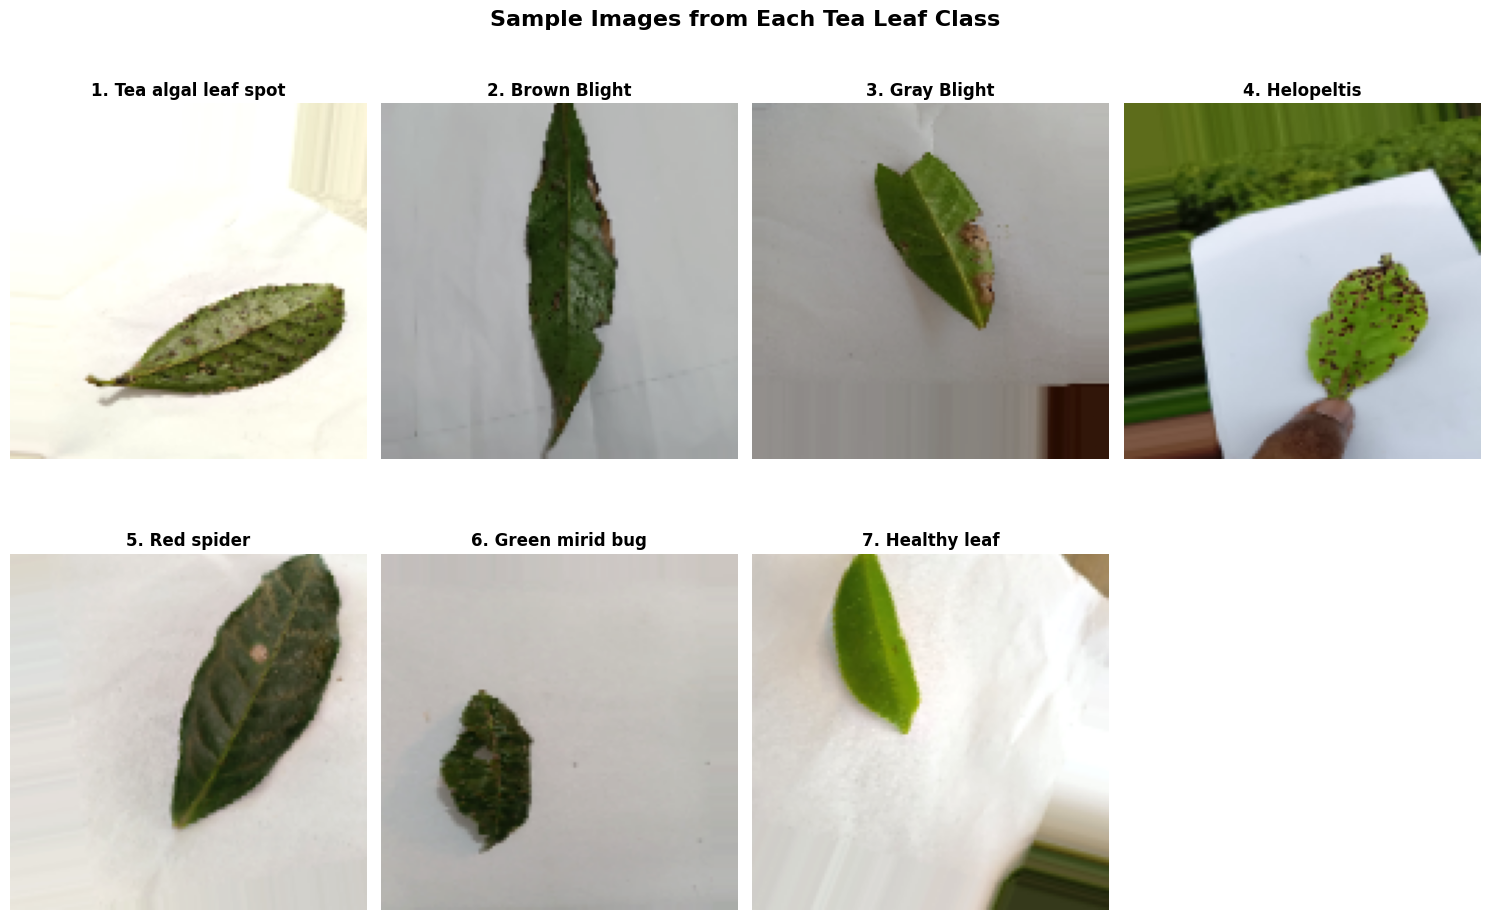

In [5]:
# Step 5: Explore Dataset

print("\nClass Labels Mapping:")
for class_name, idx in train_data.class_indices.items():
    print(f"   {idx} → {class_name}")

print(f"\nDataset Analysis:")
print(f"Total Training Samples   : {train_data.samples}")
print(f"Total Validation Samples : {val_data.samples}")
print(f"Number of Classes        : {train_data.num_classes}")

class_names = list(train_data.class_indices.keys())
plt.figure(figsize=(15, 10))

images, labels = next(train_data)

for i in range(min(len(class_names), 8)):
    plt.subplot(2, 4, i+1)
    class_indices = np.where(np.argmax(labels, axis=1) == i)[0]
    if len(class_indices) > 0:
        idx = class_indices[0]
        plt.imshow(images[idx])
        plt.title(f"{class_names[i]}", fontsize=12, fontweight='bold')
    plt.axis("off")

plt.suptitle("Sample Images from Each Tea Leaf Class", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

In [6]:
# Step 6: Build CNN Model

def create_stronger_cnn_model(num_classes):
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', padding='same',
                      input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], CHANNELS)),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2,2),
        layers.Dropout(0.25),

        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2,2),
        layers.Dropout(0.3),

        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2,2),
        layers.Dropout(0.4),

        layers.Conv2D(256, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(256, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.5),

        layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),

        layers.Dense(num_classes, activation='softmax')
    ])
    return model

num_classes = train_data.num_classes
model = create_stronger_cnn_model(num_classes)

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()
print(f"\nModel created with {num_classes} output classes")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,443,879 (5.51 MB)

 Trainable params: 1,440,423 (5.49 MB)

 Non-trainable params: 3,456 (13.50 KB)


Model created with 7 output classes


In [7]:
# Step 7: Train the CNN Model

early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    mode='max',
    verbose=1
)

checkpoint = ModelCheckpoint(
    "best_cnn_model.keras",
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,
    patience=3,
    min_lr=1e-7,
    verbose=1
)

print("Starting CNN Training... ")

history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=20,
    callbacks=[early_stop, checkpoint, reduce_lr],
    verbose=1
)

print("\nTraining finished! Best CNN model saved as 'best_cnn_model.keras'")

Starting CNN Training... 


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.1900 - loss: 3.3514
Epoch 1: val_accuracy improved from -inf to 0.11491, saving model to best_cnn_model.keras
132/132 ━━━━━━━━━━━━━━━━━━━━ 1603s 12s/step - accuracy: 0.1900 - loss: 3.3509 - val_accuracy: 0.1149 - val_loss: 2.9816 - learning_rate: 1.0000e-04
Epoch 2/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.2402 - loss: 3.0438
Epoch 2: val_accuracy did not improve from 0.11491
132/132 ━━━━━━━━━━━━━━━━━━━━ 844s 6s/step - accuracy: 0.2404 - loss: 3.0431 - val_accuracy: 0.1149 - val_loss: 6.4072 - learning_rate: 1.0000e-04
Epoch 3/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.2819 - loss: 2.8410
Epoch 3: val_accuracy did not improve from 0.11491
132/132 ━━━━━━━━━━━━━━━━━━━━ 849s 6s/step - accuracy: 0.2820 - loss: 2.8407 - val_accuracy: 0.1149 - val_loss: 9.3355 - learning_rate: 1.0000e-04
Epoch 4/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.3493 - loss: 2.6406
Epoch 4: val_accuracy impro

Loading best model for evaluation...
33/33 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.5160 - loss: 2.1291

Final Validation Accuracy: 0.5394 (53.94%)


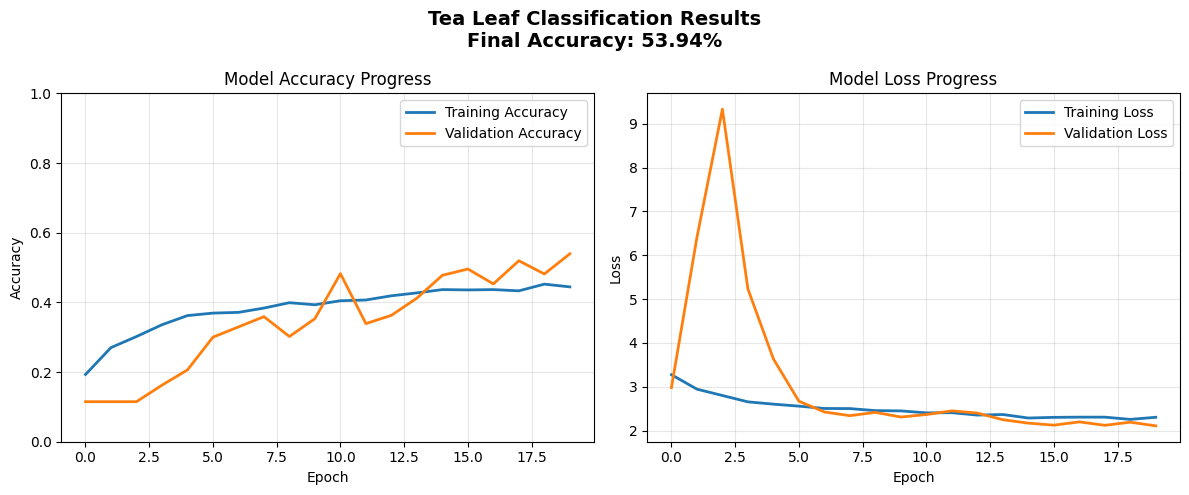


Training & Evaluation Complete!
Total Epochs Run : 20
Final Accuracy   : 53.94%
Best Model saved as: best_cnn_model.keras


In [8]:
# Step 8: Evaluate Model & Visualize Training

print("Loading best model for evaluation...")
best_model = tf.keras.models.load_model("best_cnn_model.keras")

val_loss, val_accuracy = best_model.evaluate(val_data, verbose=1)
print(f"\nFinal Validation Accuracy: {val_accuracy:.4f} ({val_accuracy*100:.2f}%)")

def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    ax1.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
    ax1.set_title('Model Accuracy Progress')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim([0, 1])

    ax2.plot(history.history['loss'], label='Training Loss', linewidth=2)
    ax2.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    ax2.set_title('Model Loss Progress')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.suptitle(f'Tea Leaf Classification Results\nFinal Accuracy: {val_accuracy*100:.2f}%', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

plot_training_history(history)

print("\nTraining & Evaluation Complete!")
print(f"Total Epochs Run : {len(history.history['accuracy'])}")
print(f"Final Accuracy   : {val_accuracy*100:.2f}%")
print("Best Model saved as: best_cnn_model.keras")